In [60]:
import pandas as pd
import math
import numpy as np
import  functools
import matplotlib.pyplot as plt
# 忽略某些warning
import warnings
from random import *

warnings.filterwarnings("ignore")


# 全局变量：服务站列表和用户列表，初始化为空，待从Excel中读入后存入
station_list = []
user_list = []

# 全局变量：等级的定义
W_list = [[2,2,10,1],[4,4,15,1.5],[8,4,20,2]]
QoE_list = [1.5, 4, 5]
max_level = 3
min_level = 1

# 初始定义最大容量
# MEC服务器类：S = [id, 该服务器可以服务的用户数量Cj, X坐标, Y坐标, 覆盖半径Rj, 分配用户目录]
class Server:
    def __init__(self, id, a, b, Rj, maxCapacity):
        # 服务器编号
        self.id = id
        # 服务器可以服务的用户的数量
        # self.Cj = Cj
        # 服务器的经度
        self.x = a
        # 服务器的纬度
        self.y = b
        # 服务器的覆盖半径
        self.Rj = Rj
        # 服务器现在服务的用户列表—— u_id 中存储的是用户的id信息
        self.users = []
        # 服务器资源上限
        self.maxCapacity = maxCapacity[:]
        # 服务器现有资源
        self.capacity = maxCapacity[:]
    def isAvailable(self, user):
        w_vector = W_list[user.W]
        for i in range(len(w_vector)):
            if(self.capacity[i] < w_vector[i]):
                return False
        return True
    def isOverLoad(self):
        for i in self.capacity:
            if i <= 0:
                return False
        return True
    def releaseUser(self, user):
        w_vector = W_list[user.pW]
        for i in range(len(w_vector)):
            self.capacity[i] += w_vector[i]
    def addUser(self, user):
        w_vector = W_list[user.W]
        for i in range(len(w_vector)):
            self.capacity[i] -= w_vector[i]


# 用户类： U = [用户id, 用户速度, 用户X坐标, 用户Y坐标, 用户移动方向, 用户被分配的站点, 用户的适应值, 用户的状态]
class User:
    def __init__(self, id, speed, X, Y, theta, h, l):
        # 用户编号
        self.id = id
        # 用户的速度
        self.speed = speed
        self.theta = theta  
        # 用户的坐标位置
        self.x = X
        self.y = Y
        # 用户移动方向
        self.alpha = [speed * math.cos(theta), speed * math.sin(theta)] # 求得方向向量alpha
        # 用户被分配的服务器的编号，编号为0即没有被分配
        self.station = None
        # 用户与被分配的服务器的适配程度
        self.M = 0
        # 分配状态
        self.status = 0
        # QoS相关参数
        self.postw = 0
        self.W = 0
        self.H = h
        self.L = l
    def update_QoS(self):
        self.pW = self.W
        self.L, self.H, self.W = sorted(np.random.choice(len(W_list), 3, replace=False))

# xy坐标计算距离dij
def get_xy_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# M值的计算
def get_M(user, server):
    # 求解余弦值cos: a·b/(|a|·|b|)    
    a = user.alpha
    b = [server.x - user.x, server.y - user.y]
    cos_theta = (a[0] * b[0] + a[1] * b[1]) / (math.sqrt((a[0])**2 + (a[1])**2) * math.sqrt((b[0])**2 + (b[1])**2))
    # 求解用户和服务器之间的距离
    dist = get_xy_distance(user.x, user.y, server.x, server.y)
    # E.q(6)
    b = 2 * dist * cos_theta
    a = 1
    c = dist**2 - server.Rj**2
    if dist < server.Rj:
        E = (-b + math.sqrt(b**2 - 4 * a *c)) / (2*a)
    else:
        return -999999
    # E.q(5)
    M = E / user.speed
    return M

# 判断某个该用户能否被分配给某个站点
def can_be_allocated(user, station):
    dis = get_xy_distance(user.x, user.y, station.x, station.y)
    if dis <= station.Rj and station.isAvailable(user):    #该站点可被分配
        return True
    return False

# 迭代某个站点内范围所有的用户，找到未被分配站点的用户
def get_unallocated(station):
    unallocated_list = []
    for user in user_list:
        dis = get_xy_distance(user.x, user.y, station.x, station.y)
        if user.status == 0 and dis <= station.Rj:    # 状态为0为未分配，且在该站点的范围内【不论是否能被分配给该站点】
            unallocated_list.append(user)
    return unallocated_list

# 得到目前没被分配的用户
def get_all_unallocated():
    all_unallocated = []
    for user in user_list:
        if user.status == 0:
            all_unallocated.append(user)
    return all_unallocated

# 某个用户可以被分配的MEC的集合
def available_station(user):
    stations = []
    for station in station_list:
        if can_be_allocated(user, station): # 可被分配，那么放入user的集合中
            stations.append(station)
    return stations

# 排序的比较函数
def compare_M(u1, u2):
    return u1.M - u2.M

# 判断用户是否有除了当前分配的站点外的其他的站点的分配可能性
def if_user_in_others(user):
    o = user.station
    for station in station_list:
        if station is not o and can_be_allocated(user, station):
            return True
    return False

# 迭代某个站点的已经分配的用户，得到可被移出的用户序列
def get_removable(station):
    users = station.users
    user_can_out = []
    for user in users:
        if if_user_in_others(user) or get_xy_distance(user.x, user.y, station.x, station.y) > station.Rj:
            user_can_out.append(user)
    return user_can_out

# 迭代某个站点的用户，得到不在服务范围内的用户列表
def get_unservable_user(station):
    users = station.users
    unservable_list = []
    for user in users:
        if ~if_user_in_others(user) and get_xy_distance(user.x, user.y, station.x, station.y) > station.Rj:
            unservable_list.append(user)
    return unservable_list

# 处理不在站点范围内的不可服务用户
def handle_unservable(station):
    unservable_list = get_unservable_user(station)
    for user in unservable_list:
        user.station = None
        user.status = 0
        user.M = -999999
        station.releaseUser(user)

# # # # # # # # # # Mobility-Aware Allocation # # # # # # # # # #
def mobility_aware_allocation(unallocated_list):
    for user in unallocated_list:  # 对每一个未分配的用户
        if user.id == 201:
            mm = 3
        ava_sta = available_station(user)   # 该用户可以被分配的MEC集合
        s = None
        M = -999999
        for station in ava_sta:
            m = get_M(user, station)    # 计算得到M值
            if m > M:
                s = station
                M = m
        user.station = s    # 最大M值的站点
        user.M = M          # 最大M值的m
    unallocated_list.sort(key=functools.cmp_to_key(compare_M), reverse = True)  # 根据M值降序排列
    for user in unallocated_list:
        s = user.station
        if s is None:
            continue
        if can_be_allocated(user, s):   # 可以分配，那么直接分配, 不能分配则不分配
            user.status = 1             # 分配后状态修改
            s.addUser(user)
        else:                           # M和station恢复成未分配的状态
            user.station = None
            user.M = 0  

# # # # # # # # # # Mobility-Aware Migration # # # # # # # # # # 
def mobility_aware_migration(o, unallocated_list, users_can_out):  
    reallocated_num = 0
    # 得到两个用户集合的并集：肯定没有交集
    union_list = unallocated_list
    for user in users_can_out:
        if user not in union_list:
            union_list.append(user)
    # 计算union_list里面的所有的用户相对于站点o的M值
    for user in union_list:
        user.M = get_M(user, o)
    # 按照M值进行降序排列
    union_list.sort(key=functools.cmp_to_key(compare_M), reverse = True)
    # 取和users_can_out大小相同的长度为migration_plan
    migration_plan = []
    for i in union_list[:len(users_can_out)]:
        if i.M > 0:
            migration_plan.append(i)
    for user in users_can_out:
        if user not in migration_plan:  # M值过低不再适合分配给当前的站
            stations = available_station(user)
            if o in stations:
                stations.remove(o)
            s = None
            M = -999999
            for station in stations: # 除了o以外的所有可分配站点
                m = get_M(user, station)    
                if m > M:
                    s = station
                    M = m 
            user.M = M
            user.station = s
            if s is None:
                o.releaseUser(user)
                continue
            s.addUser(user)
            o.releaseUser(user)         # 移出该用户 不再分配给该用户，容量增加
            reallocated_num += 1    # 重分配次数+1
    for user in unallocated_list:
        if user in migration_plan and can_be_allocated(user, o):
            user.station = o
            user.status = 1         # 修改状态为已分配
            o.addUser(user)
    return reallocated_num

# ************************ MobMig算法 ***************************
def mobMig():
    reallocated_num = 0
    for station in station_list:
        if station.isOverLoad():         # 过载的服务器
            reallocated_list = get_removable(station)
            unallocated_list = get_unallocated(station)
            reallocated_num += mobility_aware_migration(station, unallocated_list, reallocated_list)
        else:                       # 未超载的部分信息也需要更新
            handle_unservable(station)
    all_unallocated = get_all_unallocated()
    mobility_aware_allocation(all_unallocated)
    return reallocated_num

def get_border_point():
    n = user_data.shape[0]
    first = user_data.iloc[0]
    x_init = first['X']
    y_init = first['Y']
    bottom_left = [x_init, y_init]
    bottom_right = [x_init, y_init]
    upper_left = [x_init, y_init]  
    upper_right = [x_init, y_init]
    def set_border(row):
        x = row['X']
        y = row['Y']
        # 左下角
        if x < upper_left[0]:
            upper_left[0] = x
            upper_left[1] = y
        if x > bottom_right[0]:
            bottom_right[0] = x
            bottom_right[1] = y
        if y < bottom_left[1]:
            bottom_left[0] = x
            bottom_left[1] = y
        if y > upper_right[1]:
            upper_right[0] = x
            upper_right[1] = y
    user_data.apply(set_border, axis=1)
    return bottom_left, upper_left, upper_right, bottom_right

def if_in_area(M):
    def get_v(A, B):
        return (B[0]-A[0], B[1]-A[1])
    def get_x_mul(A, B):
        return A[0]*B[1] - A[1]*B[0]
    # A, B, C, D = get_border_point()
    ab = get_v(A,B)
    am = get_v(A,M)
    ad = get_v(A,D)
    bc = get_v(B,C)
    bm = get_v(B,M)
    ba = get_v(B,A)
    cd = get_v(C,D)
    cm = get_v(C,M)
    cb = get_v(C,B)
    da = get_v(D,A)
    dm = get_v(D,M)
    dc = get_v(D,C)
    v1 = -get_x_mul(ab, am)
    v2 = -get_x_mul(bc, bm)
    v3 = -get_x_mul(cd, cm)
    v4 = -get_x_mul(da, dm)
    if v1 > 0 and v2 > 0 and v3 >0 and v4 >0:
        return True
    else: 
        return False

def get_next_location(user, theta, time):
    x = user.x + time * user.speed * np.cos(theta)
    y = user.y + time * user.speed * np.sin(theta)
    return x, y

def update_location(time):
    for user in user_list:
        user.x, user.y = get_next_location(user, user.theta, time)
        max_trail = 0
        while(max_trail > 0):
            next_theta = np.random.random()*2*np.pi
            next_x, next_y = get_next_location(user, next_theta, time)
            if if_in_area([next_x, next_y]):
                user.theta = next_theta
                break
            max_trail -= 1
            
# 得到已经分配站点的用户数量
def get_status_1():
    count = 0
    for user in user_list:
        if user.status == 1:
            count += 1
    return count

# 计算当前时刻的平均覆盖率
def get_allocated_rate():
    return get_status_1()/len(user_list)

# 得到xy坐标
def get_XY(data):
    def hav(theta):
        s = math.sin(theta / 2)
        return s * s
    def get_distance_hav(lat0, lng0, lat1, lng1): 
        EARTH_RADIUS=6371
        "用haversine公式计算球面两点间的距离。"
        # 经纬度转换成弧度
        lat0 = math.radians(lat0)
        lat1 = math.radians(lat1)
        lng0 = math.radians(lng0)
        lng1 = math.radians(lng1)

        dlng = math.fabs(lng0 - lng1)
        dlat = math.fabs(lat0 - lat1)
        h = hav(dlat) + math.cos(lat0) * math.cos(lat1) * hav(dlng)
        distance = 2 * EARTH_RADIUS * math.asin(math.sqrt(h))
        return distance
    la_min = min(data['LATITUDE'])
    la_max = max(data['LATITUDE'])
    lo_min = min(data['LONGITUDE'])
    lo_max = max(data['LONGITUDE'])
    origin = (la_min, lo_min)
    bottom_right = (la_max, lo_min)
    upper_left = (la_min, lo_max)
    upper_right = (la_max, lo_max)
    delta_la = bottom_right[0] - origin[0]
    delta_ln = upper_left[1] - origin[1]
    xtotal = get_distance_hav(origin[0], origin[1], bottom_right[0], bottom_right[1])
    ytotal = get_distance_hav(origin[0], origin[1], upper_left[0], upper_right[1])
    # 经纬度差
    delta_la = bottom_right[0] - origin[0]
    delta_ln = upper_left[1] - origin[1]
    # 比例
    proportion_la = xtotal/delta_la
    proportion_ln = ytotal/delta_ln
    
    result = pd.DataFrame()
    result['Y'] = (data['LATITUDE'] - origin[0]) * proportion_la *1000
    result['X'] = (data['LONGITUDE'] - origin[1]) * proportion_ln *1000
    return result

# 计算现有的用户数量
def get_total_user():
    count = 0
    for user in user_list:
        if if_in_area([user.x, user.y]):
            count += 1
    return count

# 为已经得到服务的用户设置W值
def set_userW():
    for user in user_list:
        if user.status == 1:
            user.W = int(round(random()*(user.H - 1) + 1))

# QoE值的计算
def QoE_cal():
    Total_QoE = 0
    Emax = 5
    alpha = 1.5
    for user in user_list:
        if user.status == 1:
            gamma = get_gamma(user.W)
            beta = get_beta(user)
            Total_QoE += Emax/(1 + math.exp(-alpha * (gamma - beta)))
    return Total_QoE

# 得到gamma值
def get_gamma(level):
    return sum(W_list[int(level-1)])/4

# 得到beta值 
def get_beta(user):
    Hi = get_gamma(user.H)
    Li = get_gamma(user.L)
    return (Hi - Li)/2

# 对应时间间隔更新user的H和L
def update_user_qos():
    for user in user_list:
        user.update_QoS()
        

station_data = pd.read_csv("./data/server_la_lng_r200-400.csv")
station_number = 50
station_data = station_data.sample( n = station_number, random_state = None)     # 样本为50个站点

user_data = pd.read_csv("./data/行人_id_速度_角度.csv")
user_number = 50
user_data = user_data.sample(n = user_number, random_state = None)          # 样本为50个用户

# 用户的经纬度信息和station的经纬度合并为一个dataframe
location = pd.concat([station_data[['LONGITUDE', 'LATITUDE']], user_data[['LONGITUDE', 'LATITUDE']]])
xy = get_XY(location)
station_data['X'] = xy['X'].iloc[:len(station_data)]
user_data['X'] = xy['X'].iloc[len(station_data):len(xy)]
station_data['Y'] = xy['Y'].iloc[:len(station_data)]
user_data['Y'] = xy['Y'].iloc[len(station_data):len(xy)]

maxQos = W_list[-1]
maxCapacity = [i*user_number/station_number for i in maxQos]

# 将读入的station信息传入station_list中
for i in range(station_data.shape[0]):
    temp = station_data.iloc[i]
    station_list.append(Server(temp["SITE_ID"], temp["X"], temp["Y"], temp["r"], maxCapacity=maxCapacity))

# 将读取的用户信息传入user_list中
for i in range(user_data.shape[0]):
    temp = user_data.iloc[i]
    user_list.append(User(temp["USER_ID"], temp["v"], temp["X"], temp["Y"], temp["theta"], temp["H"], temp["L"]))

# 迭代一个很小的△t，这里为5s，得到500s内的分配的变化
delta = 5
total_time = 500
time_list = list(range(0, total_time, delta))  # 每隔5s
result = []

A, B, C, D = get_border_point()

for time in time_list:
    update_location(delta)                                                  # 更新当前的所有的用户的位置
    reallocated_num = mobMig()                                              # 使用mobMig算法分配用户
    allocated_rate = get_allocated_rate()                                   # 计算重分配率
    #total_user = get_total_user()                                           # 排除走出区域的用户，重新计算总用户数
    total_user = get_status_1()
    set_userW()                                                             #已经得到服务的用户在high和low之间设置其W值
    QoE = QoE_cal()
    res = [time, allocated_rate, reallocated_num, total_user, QoE]          # 结果列表
    result.append(res)                                                      # 结果集合
    if time % 25 == 0:
        update_user_qos()                                                           # 每隔25s更新用户的H和L值

result_data = pd.DataFrame(result, columns = ["时刻t/s", "用户覆盖率", "重分配次数/次", "已分配用户数", "QoE值"])
outputpath = "./result/" + str(user_number) + "_users_result.csv"
result_data.to_csv(outputpath, sep=',', index = False, header = True, encoding='utf-8-sig') 

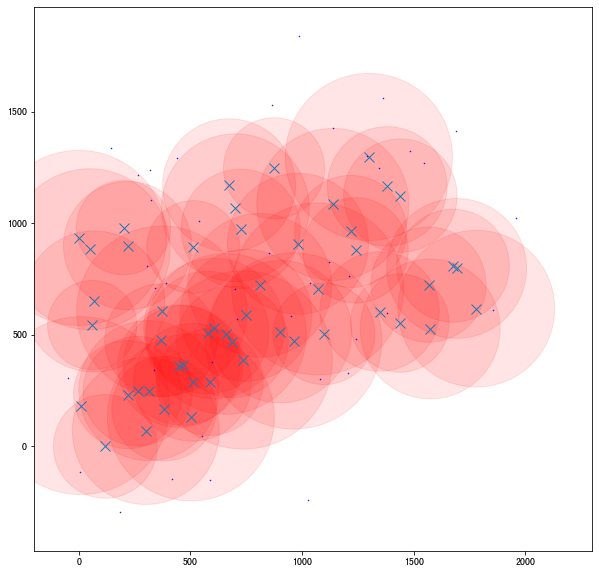

In [34]:
# 画个图
plt.figure(figsize=(10,10))
plt.axis('equal')
plt.ylim(-100, 1600)
plt.xlim(-200, 2300)
plt.plot(station_data['X'], station_data['Y'], 'x', markersize=10)
for user in user_list:
    c = 'b'
    m = 1
    plt.plot(user.x, user.y, '.', color=c, markersize=m)
# user = user_list[200]
# plt.plot(user.x, user.y, '.', color='b', markersize=4)
def plot(row):
    r = row['r']
    y = row['Y']
    x = row['X']
    c = 'r'
    circle = plt.Circle((x,y), r, color=c, fill=True, alpha=0.1)
    plt.gcf().gca().add_artist(circle)
tmp = station_data.apply(plot, axis=1)